# Simple Dadi Parameter Analysis

This notebook provides a straightforward analysis of dadi optimization results, comparing ground truth parameters with estimated values.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
# Configuration - UPDATE THESE PATHS FOR YOUR EXPERIMENT
EXPERIMENT_NAME = 'drosophila_three_epoch'  # Change this to your experiment
BASE_PATH = Path(f'/sietch_colab/akapoor/Infer_Demography/experiments/{EXPERIMENT_NAME}')
SIMULATIONS_PATH = BASE_PATH / 'simulations'
RUNS_PATH = BASE_PATH / 'runs'

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Simulations path: {SIMULATIONS_PATH}")
print(f"Runs path: {RUNS_PATH}")
print(f"Paths exist: {SIMULATIONS_PATH.exists()}, {RUNS_PATH.exists()}")

Experiment: drosophila_three_epoch
Simulations path: /sietch_colab/akapoor/Infer_Demography/experiments/drosophila_three_epoch/simulations
Runs path: /sietch_colab/akapoor/Infer_Demography/experiments/drosophila_three_epoch/runs
Paths exist: True, True


In [11]:
def load_ground_truth(simulations_path):
    """Load ground truth parameters from simulation directories."""
    gt_data = {}
    
    for sim_dir in sorted(simulations_path.glob('*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                gt_data[sim_id] = params
            except Exception as e:
                print(f"Error loading {param_file}: {e}")
    
    print(f"Loaded ground truth for {len(gt_data)} simulations")
    return gt_data

def load_coverage_data(simulations_path):
    """Load coverage percentage data from bgs.meta.json files."""
    coverage_data = {}
    
    for sim_dir in sorted(simulations_path.glob('*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name
        meta_file = sim_dir / 'bgs.meta.json'
        
        if meta_file.exists():
            try:
                with open(meta_file, 'r') as f:
                    meta = json.load(f)
                coverage_data[sim_id] = meta.get('sampled_coverage_percent', None)
            except Exception as e:
                print(f"Error loading {meta_file}: {e}")
                coverage_data[sim_id] = None
        else:
            coverage_data[sim_id] = None
    
    print(f"Loaded coverage data for {len(coverage_data)} simulations")
    valid_coverage = sum(1 for v in coverage_data.values() if v is not None)
    print(f"  {valid_coverage} simulations have coverage data")
    return coverage_data

def load_dadi_results(runs_path):
    """Load dadi optimization results."""
    results = {}
    
    for run_dir in sorted(runs_path.glob('run_*_*')):
        if not run_dir.is_dir():
            continue
            
        # Parse run directory name: run_sim_rep
        parts = run_dir.name.split('_')
        if len(parts) < 3:
            continue
            
        sim_id = parts[1]
        rep_id = parts[2]
        
        dadi_dir = run_dir / 'inferences' / 'dadi'
        if not dadi_dir.exists():
            continue
            
        # Look for results file
        result_files = [
            dadi_dir / 'best_fit.pkl',
            dadi_dir / 'results.pkl',
            dadi_dir / 'optimization_results.pkl'
        ]
        
        for result_file in result_files:
            if result_file.exists():
                try:
                    with open(result_file, 'rb') as f:
                        data = pickle.load(f)
                    
                    if sim_id not in results:
                        results[sim_id] = {}
                    results[sim_id][rep_id] = data
                    break  # Use first found file
                except Exception as e:
                    print(f"Error loading {result_file}: {e}")
    
    print(f"Loaded dadi results for {len(results)} simulations")
    return results

def extract_parameters(dadi_data):
    """Extract parameters and likelihood from dadi results."""
    params = {}
    likelihood = None
    
    # Handle different result file formats
    if isinstance(dadi_data, dict):
        # Format 1: param_order + opt_params + opt_ll (your current format)
        if 'param_order' in dadi_data and 'opt_params' in dadi_data:
            param_order = dadi_data['param_order']
            param_values = dadi_data['opt_params']
            if len(param_order) == len(param_values):
                params = dict(zip(param_order, param_values))
            
            # Get likelihood
            if 'opt_ll' in dadi_data:
                likelihood = dadi_data['opt_ll']
        
        # Format 2: best_params as dict + best_ll/log_likelihood/ll
        elif 'best_params' in dadi_data:
            if isinstance(dadi_data['best_params'], dict):
                params = dadi_data['best_params']
            elif 'param_order' in dadi_data:
                order = dadi_data['param_order']
                values = dadi_data['best_params']
                params = dict(zip(order, values))
        
            # Look for likelihood
            for key in ['best_ll', 'log_likelihood', 'll']:
                if key in dadi_data:
                    val = dadi_data[key]
                    likelihood = val[0] if isinstance(val, (list, tuple)) else val
                    break
        
        # Format 3: Direct parameter names as keys
        else:
            # Look for common demographic parameter names
            param_keys = [k for k in dadi_data.keys() if not k.startswith('_') and k not in ['ll', 'log_likelihood', 'best_ll', 'opt_ll']]
            for key in param_keys:
                if isinstance(dadi_data[key], (int, float)):
                    params[key] = dadi_data[key]
            
            # Look for likelihood
            for key in ['best_ll', 'log_likelihood', 'll', 'opt_ll']:
                if key in dadi_data:
                    val = dadi_data[key]
                    likelihood = val[0] if isinstance(val, (list, tuple)) else val
                    break
    
    if likelihood is not None:
        params['log_likelihood'] = float(likelihood)
    
    return params

print("Helper functions defined!")

Helper functions defined!


In [12]:
# Load the data
print("Loading ground truth parameters...")
ground_truth = load_ground_truth(SIMULATIONS_PATH)

print("\nLoading coverage data...")
coverage_data = load_coverage_data(SIMULATIONS_PATH)

print("\nLoading dadi results...")
dadi_results = load_dadi_results(RUNS_PATH)

# Show example data
if ground_truth:
    first_sim = list(ground_truth.keys())[0]
    print(f"\nExample ground truth parameters (sim {first_sim}):")
    for key, value in ground_truth[first_sim].items():
        print(f"  {key}: {value}")

if coverage_data:
    print(f"\nExample coverage data:")
    for i, (sim_id, coverage) in enumerate(list(coverage_data.items())[:5]):
        print(f"  Sim {sim_id}: {coverage}% coverage" if coverage else f"  Sim {sim_id}: No coverage data")

if dadi_results:
    first_sim = list(dadi_results.keys())[0]
    first_rep = list(dadi_results[first_sim].keys())[0]
    example_params = extract_parameters(dadi_results[first_sim][first_rep])
    print(f"\nExample estimated parameters (sim {first_sim}, rep {first_rep}):")
    for key, value in example_params.items():
        print(f"  {key}: {value}")

Loading ground truth parameters...
Loaded ground truth for 50 simulations

Loading coverage data...
Loaded coverage data for 50 simulations
  0 simulations have coverage data

Loading dadi results...
Loaded dadi results for 35 simulations

Example ground truth parameters (sim 0):
  N0: 16609.340728339448
  AFR: 15971.960993801307
  EUR_bottleneck: 4321.270015574636
  EUR_recover: 14249.992552127915
  T_AFR_expansion: 64126.60218314743
  T_AFR_EUR_split: 48049.271713833485
  T_EUR_expansion: 6969.687466918001

Example coverage data:
  Sim 0: No coverage data
  Sim 1: No coverage data
  Sim 10: No coverage data
  Sim 11: No coverage data
  Sim 12: No coverage data

Example estimated parameters (sim 0, rep 0):
  N0: 16115.649999775856
  AFR: 15890.51585780574
  EUR_bottleneck: 4315.461830997264
  EUR_recover: 15047.288250652664
  T_AFR_expansion: 146826.3052775534
  T_AFR_EUR_split: 47953.88732711561
  T_EUR_expansion: 6518.596570936435
  log_likelihood: 472294.4871169239


In [13]:
# Create comparison dataframe
comparison_data = []

print("Debug: Starting comparison data creation...")
print(f"Ground truth simulations: {sorted(ground_truth.keys())}")
print(f"dadi results simulations: {sorted(dadi_results.keys())}")

# Find overlap
gt_sims = set(ground_truth.keys())
dadi_sims = set(dadi_results.keys())
overlap = gt_sims & dadi_sims
print(f"Overlapping simulations: {sorted(overlap)}")

if not overlap:
    print("❌ ERROR: No overlapping simulations between ground truth and dadi results!")
    print("This is why the comparison dataframe is empty.")
else:
    print(f"✅ Found {len(overlap)} overlapping simulations")

for sim_id in ground_truth.keys():
    if sim_id not in dadi_results:
        print(f"Simulation {sim_id}: No dadi results found")
        continue
        
    gt_params = ground_truth[sim_id]
    coverage = coverage_data.get(sim_id, None)  # Get coverage for this simulation
    
    print(f"Processing simulation {sim_id}:")
    print(f"  Ground truth params: {list(gt_params.keys())}")
    print(f"  Number of replicates: {len(dadi_results[sim_id])}")
    
    for rep_id, rep_data in dadi_results[sim_id].items():
        est_params = extract_parameters(rep_data)
        print(f"  Replicate {rep_id}: Estimated params: {list(est_params.keys())}")
        
        # Find common parameters
        common_params = set(gt_params.keys()) & set(est_params.keys())
        common_params.discard('log_likelihood')  # Don't compare likelihood
        
        print(f"  Common parameters: {list(common_params)}")
        
        if not common_params:
            print(f"    ⚠️  No common parameters found for sim {sim_id}, rep {rep_id}")
            continue
        
        for param in common_params:
            gt_val = gt_params[param]
            est_val = est_params[param]
            
            comparison_data.append({
                'simulation': sim_id,
                'replicate': rep_id,
                'parameter': param,
                'ground_truth': gt_val,
                'estimated': est_val,
                'absolute_error': est_val - gt_val,
                'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan,
                'coverage_percent': coverage
            })
        
        # Add likelihood separately
        if 'log_likelihood' in est_params:
            comparison_data.append({
                'simulation': sim_id,
                'replicate': rep_id,
                'parameter': 'log_likelihood',
                'ground_truth': np.nan,
                'estimated': est_params['log_likelihood'],
                'absolute_error': np.nan,
                'relative_error': np.nan,
                'coverage_percent': coverage
            })

print(f"\nTotal comparison data rows created: {len(comparison_data)}")

if len(comparison_data) == 0:
    print("❌ ERROR: No comparison data was created!")
    print("Possible issues:")
    print("1. No overlapping simulations between ground truth and dadi results")
    print("2. No common parameters between ground truth and estimated parameters")
    print("3. Issue with extract_parameters function")
    
    # Let's examine the first dadi result in detail
    if dadi_results:
        first_sim = list(dadi_results.keys())[0]
        first_rep = list(dadi_results[first_sim].keys())[0]
        print(f"\nExamining first dadi result (sim {first_sim}, rep {first_rep}):")
        print(f"Raw data type: {type(dadi_results[first_sim][first_rep])}")
        print(f"Raw data keys: {list(dadi_results[first_sim][first_rep].keys()) if isinstance(dadi_results[first_sim][first_rep], dict) else 'Not a dict'}")
        
        # Try extract_parameters and see what happens
        extracted = extract_parameters(dadi_results[first_sim][first_rep])
        print(f"Extracted parameters: {extracted}")
    
    # Create an empty DataFrame to avoid the error
    df = pd.DataFrame()
else:
    df = pd.DataFrame(comparison_data)
    print(f"Created comparison dataframe with {len(df)} rows")
    print(f"Parameters: {sorted(df['parameter'].unique())}")
    print(f"Simulations: {len(df['simulation'].unique())}")

    # Check coverage data distribution
    if 'coverage_percent' in df.columns:
        coverage_stats = df['coverage_percent'].describe()
        print(f"\nCoverage percentage statistics:")
        print(coverage_stats)

    # Show first few rows
    if len(df) > 0:
        display(df.head(10))

Debug: Starting comparison data creation...
Ground truth simulations: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7', '8', '9']
dadi results simulations: ['0', '1', '11', '12', '16', '17', '19', '2', '20', '23', '24', '26', '27', '28', '3', '30', '31', '32', '33', '34', '35', '36', '38', '39', '4', '41', '42', '43', '45', '46', '47', '49', '5', '8', '9']
Overlapping simulations: ['0', '1', '11', '12', '16', '17', '19', '2', '20', '23', '24', '26', '27', '28', '3', '30', '31', '32', '33', '34', '35', '36', '38', '39', '4', '41', '42', '43', '45', '46', '47', '49', '5', '8', '9']
✅ Found 35 overlapping simulations
Processing simulation 0:
  Ground truth params: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansi

,simulation,replicate,parameter,ground_truth,estimated,absolute_error,relative_error,coverage_percent
0,0,0,AFR,15971.960994,15890.515858,-81.445136,-0.005099,None
1,0,0,T_EUR_expansion,6969.687467,6518.596571,-451.090896,-0.064722,None
2,0,0,N0,16609.340728,16115.650000,-493.690729,-0.029724,None
3,0,0,EUR_bottleneck,4321.270016,4315.461831,-5.808185,-0.001344,None
4,0,0,EUR_recover,14249.992552,15047.288251,797.295699,0.055951,None
5,0,0,T_AFR_EUR_split,48049.271714,47953.887327,-95.384387,-0.001985,None
6,0,0,T_AFR_expansion,64126.602183,146826.305278,82699.703094,1.289632,None
7,0,0,log_likelihood,NaN,472294.487117,NaN,NaN,None
8,1,0,AFR,6094.383091,6096.790027,2.406936,0.000395,None
9,1,0,T_EUR_expansion,6890.234310,6969.175803,78.941493,0.011457,None


Plotting 7 parameters: ['AFR', 'T_EUR_expansion', 'N0', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_EUR_split', 'T_AFR_expansion']


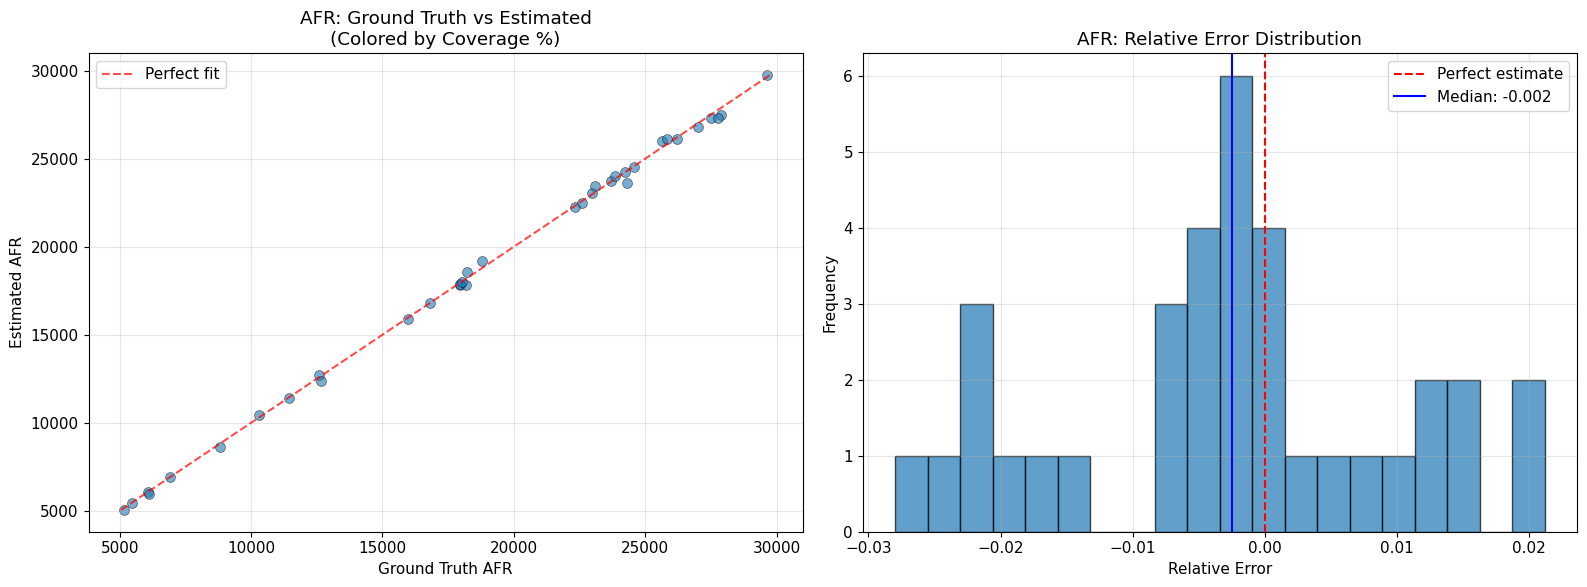


AFR Statistics:
  Estimates: 35
  Correlation: 0.9995
  RMSE: 235.1909
  Mean relative error: -0.0029
  Std relative error: 0.0127




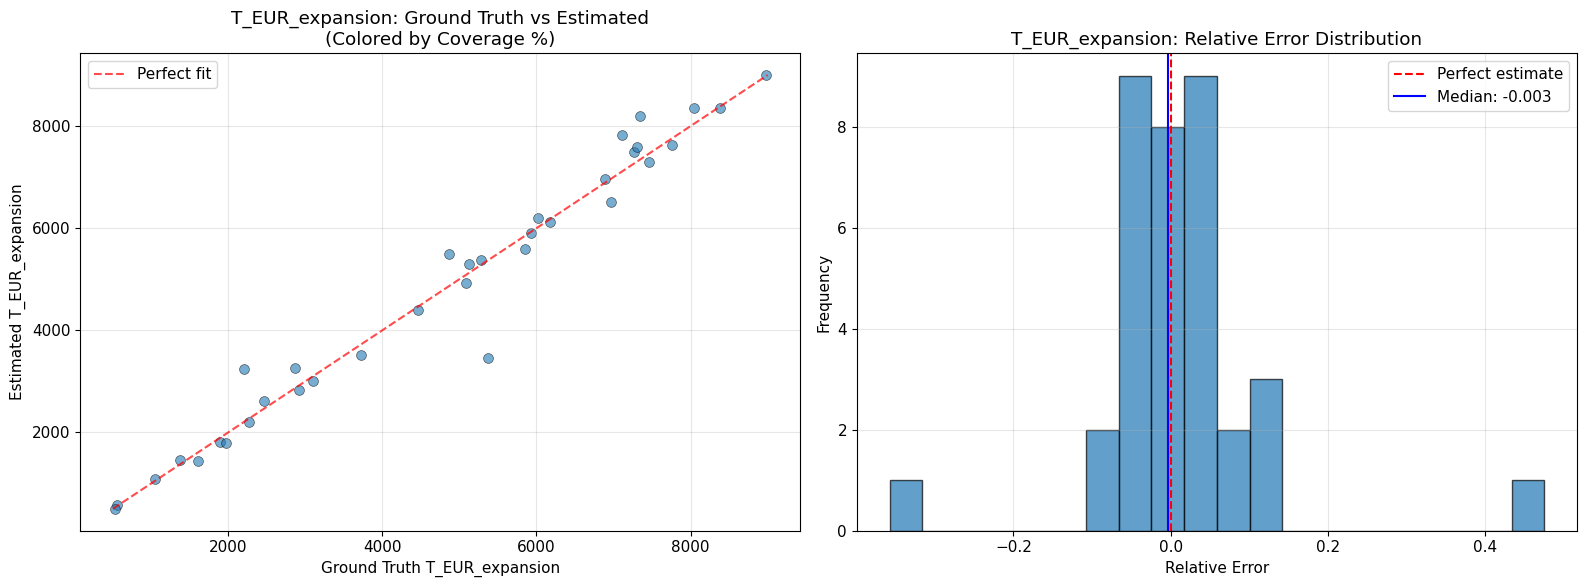


T_EUR_expansion Statistics:
  Estimates: 35
  Correlation: 0.9836
  RMSE: 458.4120
  Mean relative error: 0.0090
  Std relative error: 0.1167




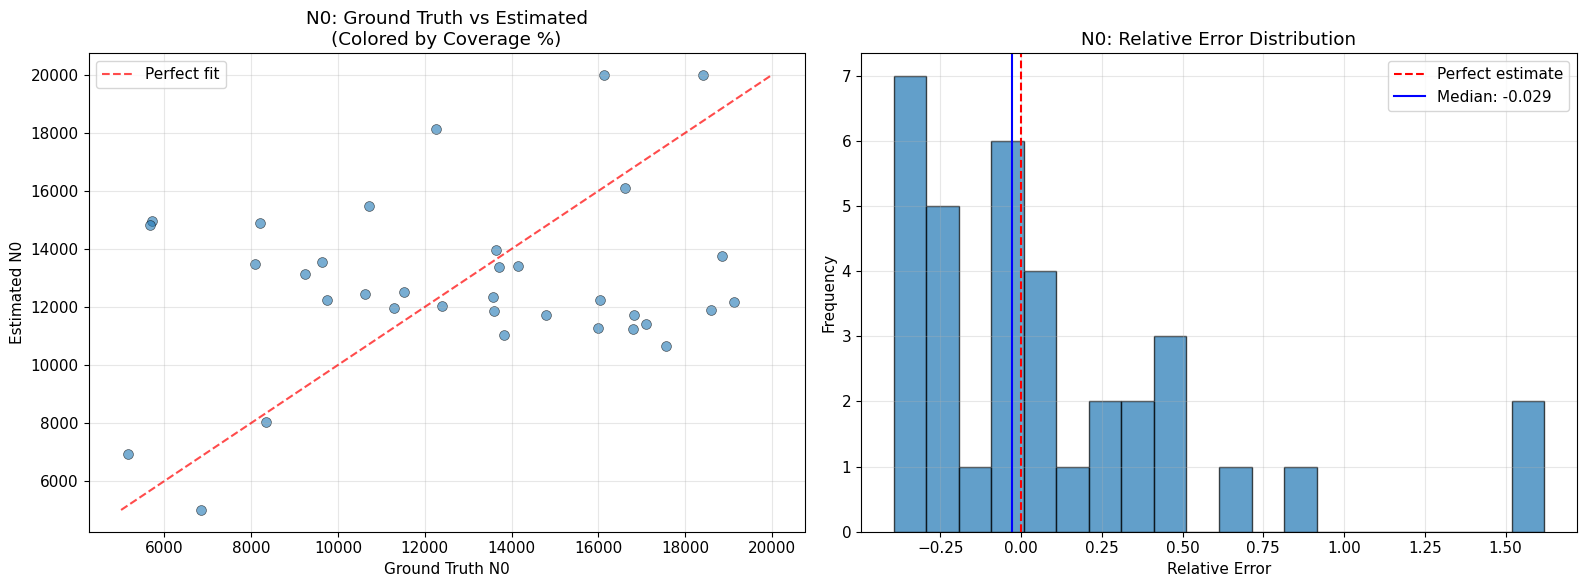


N0 Statistics:
  Estimates: 35
  Correlation: 0.2378
  RMSE: 4411.6350
  Mean relative error: 0.1082
  Std relative error: 0.4886




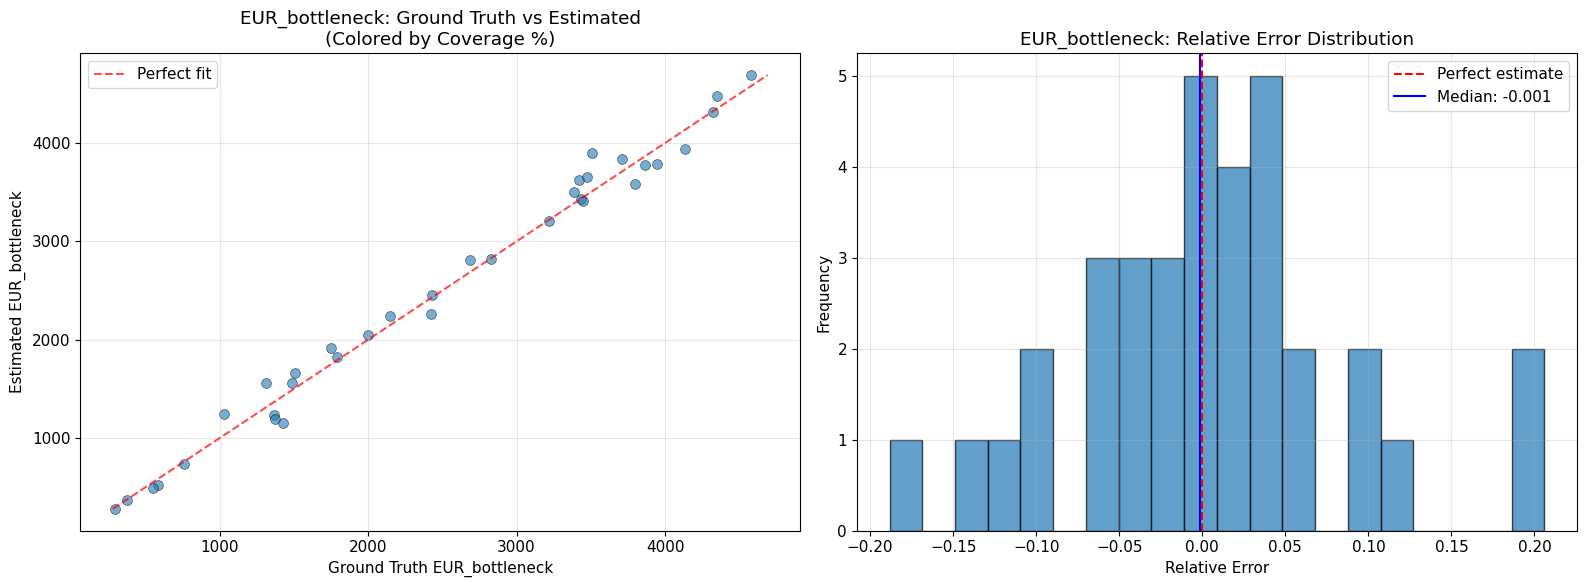


EUR_bottleneck Statistics:
  Estimates: 35
  Correlation: 0.9938
  RMSE: 145.9836
  Mean relative error: 0.0034
  Std relative error: 0.0817




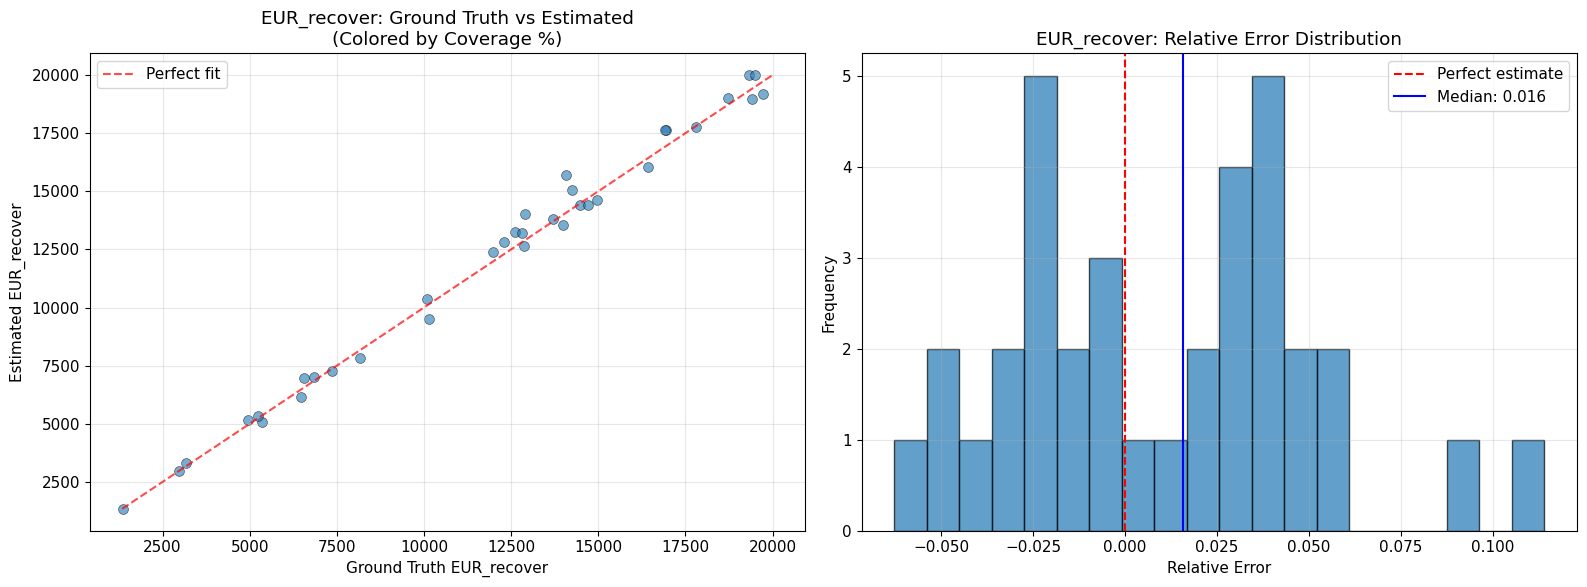


EUR_recover Statistics:
  Estimates: 35
  Correlation: 0.9957
  RMSE: 519.8228
  Mean relative error: 0.0109
  Std relative error: 0.0408




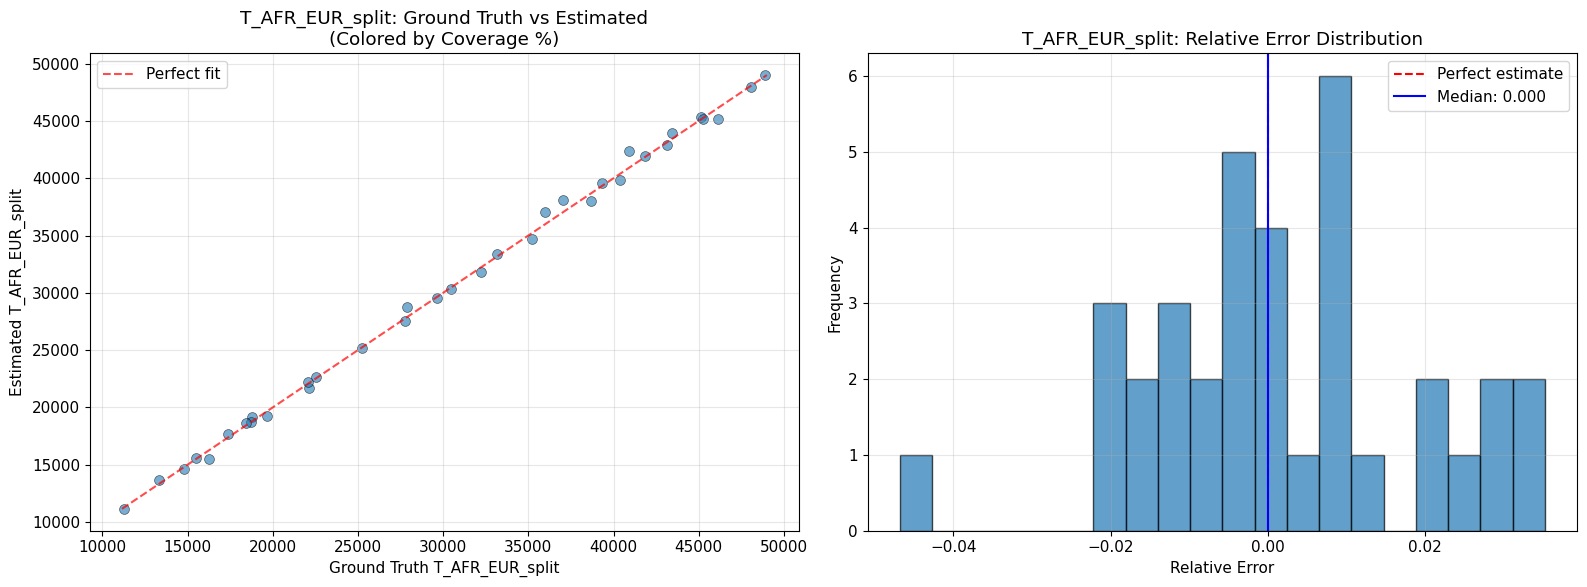


T_AFR_EUR_split Statistics:
  Estimates: 35
  Correlation: 0.9990
  RMSE: 514.8485
  Mean relative error: 0.0013
  Std relative error: 0.0175




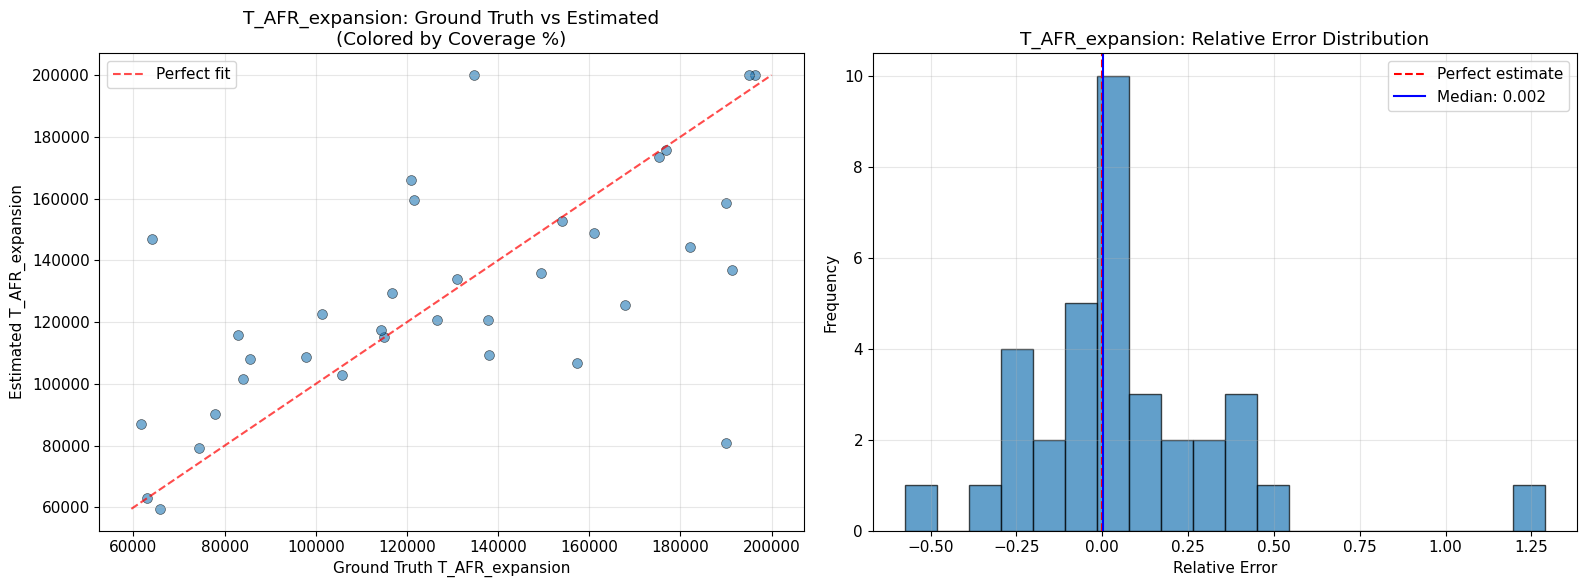


T_AFR_expansion Statistics:
  Estimates: 35
  Correlation: 0.6302
  RMSE: 34352.6035
  Mean relative error: 0.0570
  Std relative error: 0.3113


Cross-Parameter Analysis:
Not enough migration parameters found for cross-parameter analysis


In [14]:
# Plot parameter comparisons
def plot_parameter(df, param_name):
    """Plot ground truth vs estimated for a parameter, colored by coverage percentage."""
    param_data = df[df['parameter'] == param_name]
    
    if len(param_data) == 0:
        print(f"No data for parameter {param_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot colored by coverage
    coverage = param_data['coverage_percent']
    
    # Handle case where some coverage data might be missing
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = ax1.scatter(param_data[valid_coverage]['ground_truth'], 
                            param_data[valid_coverage]['estimated'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(param_data):
            ax1.scatter(param_data[~valid_coverage]['ground_truth'], 
                       param_data[~valid_coverage]['estimated'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        ax1.scatter(param_data['ground_truth'], param_data['estimated'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect fit')
    
    ax1.set_xlabel(f'Ground Truth {param_name}')
    ax1.set_ylabel(f'Estimated {param_name}')
    ax1.set_title(f'{param_name}: Ground Truth vs Estimated\n(Colored by Coverage %)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Error histogram
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
    
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{param_name}: Relative Error Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    valid_data = param_data.dropna(subset=['ground_truth', 'estimated'])
    if len(valid_data) > 0:
        corr = valid_data['ground_truth'].corr(valid_data['estimated'])
        rmse = np.sqrt((valid_data['absolute_error']**2).mean())
        print(f"\n{param_name} Statistics:")
        print(f"  Estimates: {len(valid_data)}")
        print(f"  Correlation: {corr:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        if len(valid_errors) > 0:
            print(f"  Mean relative error: {valid_errors.mean():.4f}")
            print(f"  Std relative error: {valid_errors.std():.4f}")
        
        # Coverage-related statistics
        coverage_valid = valid_data['coverage_percent'].notna()
        if coverage_valid.sum() > 0:
            print(f"  Coverage range: {valid_data['coverage_percent'].min():.1f}% - {valid_data['coverage_percent'].max():.1f}%")
            print(f"  Mean coverage: {valid_data['coverage_percent'].mean():.1f}%")

def plot_cross_parameter(df, param1_est, param2_gt, title_suffix=""):
    """Plot estimated param1 vs ground truth param2 to check for parameter confusion, colored by coverage."""
    # Get data for both parameters
    param1_data = df[df['parameter'] == param1_est][['simulation', 'replicate', 'estimated', 'coverage_percent']].rename(columns={'estimated': f'{param1_est}_estimated'})
    param2_data = df[df['parameter'] == param2_gt][['simulation', 'replicate', 'ground_truth']].rename(columns={'ground_truth': f'{param2_gt}_ground_truth'})
    
    # Merge data
    merged_data = pd.merge(param1_data, param2_data, on=['simulation', 'replicate'], how='inner')
    
    if len(merged_data) == 0:
        print(f"No overlapping data for {param1_est} estimated vs {param2_gt} ground truth")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Scatter plot colored by coverage
    coverage = merged_data['coverage_percent']
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = plt.scatter(merged_data[valid_coverage][f'{param2_gt}_ground_truth'], 
                            merged_data[valid_coverage][f'{param1_est}_estimated'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(merged_data):
            plt.scatter(merged_data[~valid_coverage][f'{param2_gt}_ground_truth'], 
                       merged_data[~valid_coverage][f'{param1_est}_estimated'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        plt.scatter(merged_data[f'{param2_gt}_ground_truth'], merged_data[f'{param1_est}_estimated'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    plt.xlabel(f'Ground Truth {param2_gt}')
    plt.ylabel(f'Estimated {param1_est}')
    plt.title(f'Cross-Parameter Analysis: {param1_est} Estimated vs {param2_gt} Ground Truth{title_suffix}\n(Colored by Coverage %)')
    plt.grid(True, alpha=0.3)
    
    # Calculate correlation
    corr = merged_data[f'{param2_gt}_ground_truth'].corr(merged_data[f'{param1_est}_estimated'])
    plt.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Cross-parameter correlation ({param1_est} est vs {param2_gt} gt): {corr:.4f}")
    print(f"Data points: {len(merged_data)}")
    
    return corr

# Plot each parameter
parameters = [p for p in df['parameter'].unique() if p != 'log_likelihood']
print(f"Plotting {len(parameters)} parameters: {parameters}")

for param in parameters:
    plot_parameter(df, param)
    print("\n" + "="*60 + "\n")

# Cross-parameter analysis
print("Cross-Parameter Analysis:")
print("="*50)

# Check for parameter confusion between migration rates
available_params = df['parameter'].unique()
migration_params = [p for p in available_params if 'm' in p.lower() and p != 'log_likelihood']

if len(migration_params) >= 2:
    print(f"Found migration parameters: {migration_params}")
    
    # Plot m12 estimated vs m21 ground truth (and vice versa)
    for i, param1 in enumerate(migration_params):
        for j, param2 in enumerate(migration_params):
            if i != j:  # Don't compare parameter with itself
                print(f"\nAnalyzing: {param1} estimated vs {param2} ground truth")
                corr = plot_cross_parameter(df, param1, param2)
                print("-" * 40)
else:
    print("Not enough migration parameters found for cross-parameter analysis")
    
# You can also check other parameter pairs
other_cross_checks = [
    # Add any other parameter pairs you want to check, e.g.:
    # ('N_YRI', 'N_CEU'),
    # ('T_split', 'N_anc'),
]

for param1, param2 in other_cross_checks:
    if param1 in available_params and param2 in available_params:
        print(f"\nAnalyzing: {param1} estimated vs {param2} ground truth")
        plot_cross_parameter(df, param1, param2)
        print("-" * 40)

Best Estimates Summary (Highest Likelihood per Simulation):

AFR:
  Count: 35
  Mean relative error: -0.0029
  Std relative error: 0.0127
  Within 5%: 35/35 (100.0%)
  Within 10%: 35/35 (100.0%)

T_EUR_expansion:
  Count: 35
  Mean relative error: 0.0090
  Std relative error: 0.1167
  Within 5%: 22/35 (62.9%)
  Within 10%: 29/35 (82.9%)

N0:
  Count: 35
  Mean relative error: 0.1082
  Std relative error: 0.4886
  Within 5%: 5/35 (14.3%)
  Within 10%: 10/35 (28.6%)

EUR_bottleneck:
  Count: 35
  Mean relative error: 0.0034
  Std relative error: 0.0817
  Within 5%: 20/35 (57.1%)
  Within 10%: 28/35 (80.0%)

EUR_recover:
  Count: 35
  Mean relative error: 0.0109
  Std relative error: 0.0408
  Within 5%: 28/35 (80.0%)
  Within 10%: 34/35 (97.1%)

T_AFR_EUR_split:
  Count: 35
  Mean relative error: 0.0013
  Std relative error: 0.0175
  Within 5%: 35/35 (100.0%)
  Within 10%: 35/35 (100.0%)

T_AFR_expansion:
  Count: 35
  Mean relative error: 0.0570
  Std relative error: 0.3113
  Within 5%: 

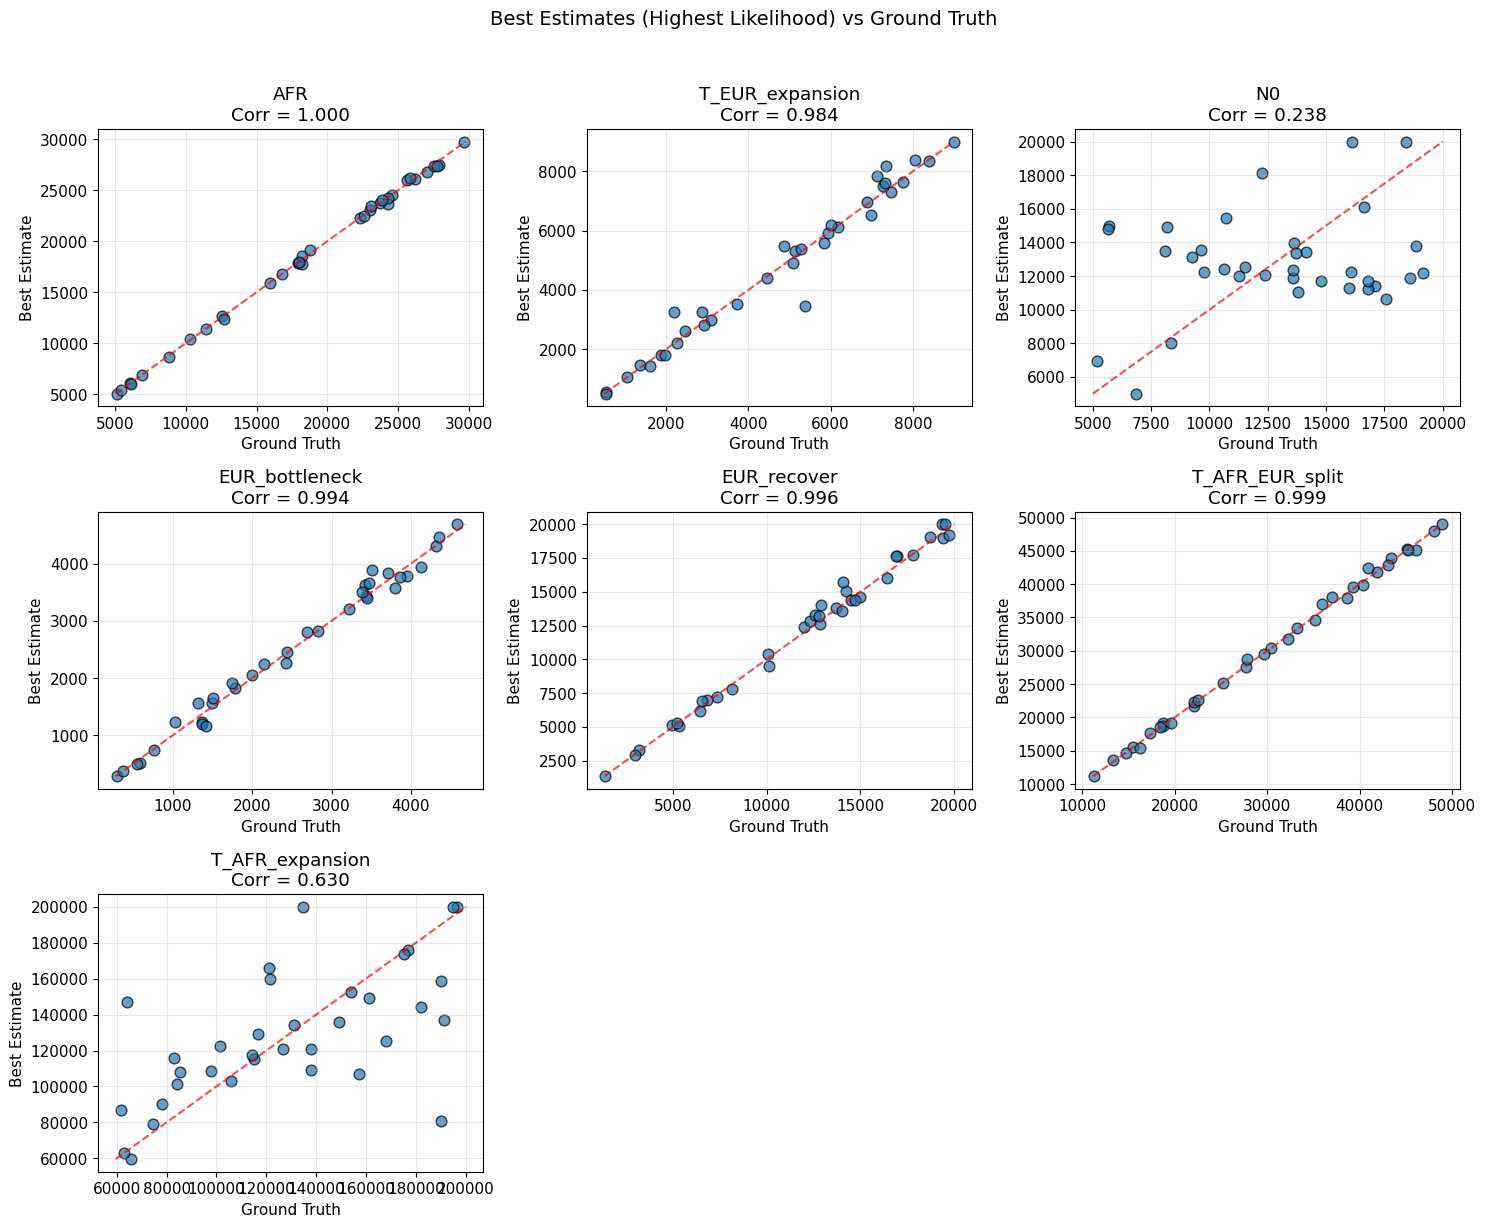

In [15]:
# Best estimates analysis (highest likelihood per simulation)
ll_data = df[df['parameter'] == 'log_likelihood']

if not ll_data.empty:
    best_estimates = []
    
    for sim_id in ll_data['simulation'].unique():
        sim_ll = ll_data[ll_data['simulation'] == sim_id]
        best_rep = sim_ll.loc[sim_ll['estimated'].idxmax(), 'replicate']
        
        # Get all parameters for this simulation's best replicate
        best_data = df[(df['simulation'] == sim_id) & 
                      (df['replicate'] == best_rep) & 
                      (df['parameter'] != 'log_likelihood')]
        
        for _, row in best_data.iterrows():
            best_estimates.append({
                'simulation': row['simulation'],
                'parameter': row['parameter'],
                'ground_truth': row['ground_truth'],
                'best_estimate': row['estimated'],
                'relative_error': row['relative_error']
            })
    
    best_df = pd.DataFrame(best_estimates)
    
    if not best_df.empty:
        print("Best Estimates Summary (Highest Likelihood per Simulation):")
        print("=" * 60)
        
        for param in best_df['parameter'].unique():
            param_data = best_df[best_df['parameter'] == param]
            
            print(f"\n{param}:")
            print(f"  Count: {len(param_data)}")
            print(f"  Mean relative error: {param_data['relative_error'].mean():.4f}")
            print(f"  Std relative error: {param_data['relative_error'].std():.4f}")
            
            # Accuracy within thresholds
            within_5pct = (np.abs(param_data['relative_error']) <= 0.05).sum()
            within_10pct = (np.abs(param_data['relative_error']) <= 0.10).sum()
            total = len(param_data)
            print(f"  Within 5%: {within_5pct}/{total} ({100*within_5pct/total:.1f}%)")
            print(f"  Within 10%: {within_10pct}/{total} ({100*within_10pct/total:.1f}%)")
        
        # Plot best estimates
        params = best_df['parameter'].unique()
        n_params = len(params)
        
        if n_params > 0:
            cols = min(3, n_params)
            rows = (n_params + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
            if n_params == 1:
                axes = [axes]
            elif rows == 1:
                axes = [axes] if cols == 1 else axes
            else:
                axes = axes.flatten()
            
            for i, param in enumerate(params):
                ax = axes[i]
                param_data = best_df[best_df['parameter'] == param]
                
                ax.scatter(param_data['ground_truth'], param_data['best_estimate'], 
                          alpha=0.7, s=60, edgecolors='black')
                
                # Identity line
                min_val = min(param_data['ground_truth'].min(), param_data['best_estimate'].min())
                max_val = max(param_data['ground_truth'].max(), param_data['best_estimate'].max())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
                
                # Correlation
                corr = param_data['ground_truth'].corr(param_data['best_estimate'])
                ax.set_title(f'{param}\nCorr = {corr:.3f}')
                ax.set_xlabel('Ground Truth')
                ax.set_ylabel('Best Estimate')
                ax.grid(True, alpha=0.3)
            
            # Hide unused subplots
            for i in range(n_params, len(axes)):
                axes[i].set_visible(False)
            
            plt.suptitle('Best Estimates (Highest Likelihood) vs Ground Truth', 
                        fontsize=14, y=1.02)
            plt.tight_layout()
            plt.show()
    
else:
    print("No likelihood data found - cannot identify best estimates")

In [16]:
# Summary statistics by parameter
print("Overall Parameter Statistics:")
print("=" * 50)

for param in [p for p in df['parameter'].unique() if p != 'log_likelihood']:
    param_data = df[df['parameter'] == param]
    
    print(f"\n{param}:")
    print(f"  Total estimates: {len(param_data)}")
    print(f"  Simulations: {len(param_data['simulation'].unique())}")
    
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        print(f"  Mean relative error: {valid_errors.mean():.4f}")
        print(f"  Median relative error: {valid_errors.median():.4f}")
        print(f"  Std relative error: {valid_errors.std():.4f}")
        
        # Percentiles
        p25, p75 = np.percentile(np.abs(valid_errors), [25, 75])
        print(f"  25th percentile |error|: {p25:.4f}")
        print(f"  75th percentile |error|: {p75:.4f}")

print("\n" + "="*50)
print("Analysis complete!")

Overall Parameter Statistics:

AFR:
  Total estimates: 35
  Simulations: 35
  Mean relative error: -0.0029
  Median relative error: -0.0025
  Std relative error: 0.0127
  25th percentile |error|: 0.0027
  75th percentile |error|: 0.0161

T_EUR_expansion:
  Total estimates: 35
  Simulations: 35
  Mean relative error: 0.0090
  Median relative error: -0.0034
  Std relative error: 0.1167
  25th percentile |error|: 0.0218
  75th percentile |error|: 0.0640

N0:
  Total estimates: 35
  Simulations: 35
  Mean relative error: 0.1082
  Median relative error: -0.0288
  Std relative error: 0.4886
  25th percentile |error|: 0.0887
  75th percentile |error|: 0.3796

EUR_bottleneck:
  Total estimates: 35
  Simulations: 35
  Mean relative error: 0.0034
  Median relative error: -0.0013
  Std relative error: 0.0817
  25th percentile |error|: 0.0235
  75th percentile |error|: 0.0963

EUR_recover:
  Total estimates: 35
  Simulations: 35
  Mean relative error: 0.0109
  Median relative error: 0.0158
  Std r

EUR_bottleneck vs EUR_recover Cross-Parameter Analysis
Available parameters: ['N0', 'T_AFR_expansion', 'T_AFR_EUR_split', 'EUR_bottleneck', 'T_EUR_expansion', 'EUR_recover', 'AFR', 'log_likelihood']
Has EUR_bottleneck: True
Has EUR_recover: True

1. EUR_bottleneck estimated vs EUR_recover ground truth


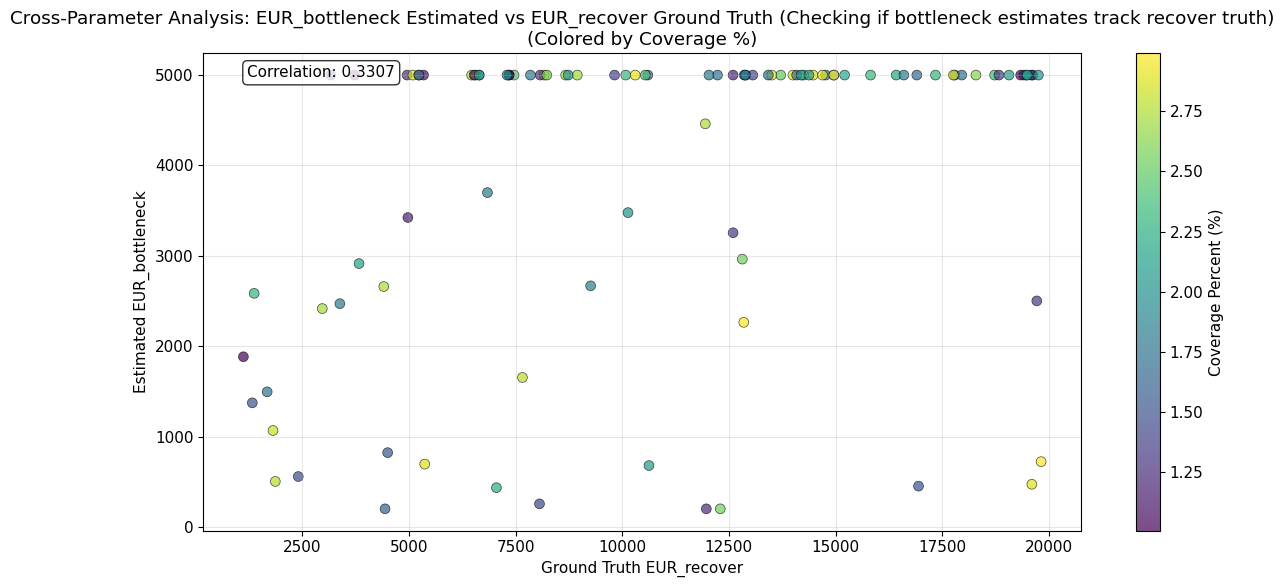

Cross-parameter correlation (EUR_bottleneck est vs EUR_recover gt): 0.3307
Data points: 100

2. EUR_recover estimated vs EUR_bottleneck ground truth


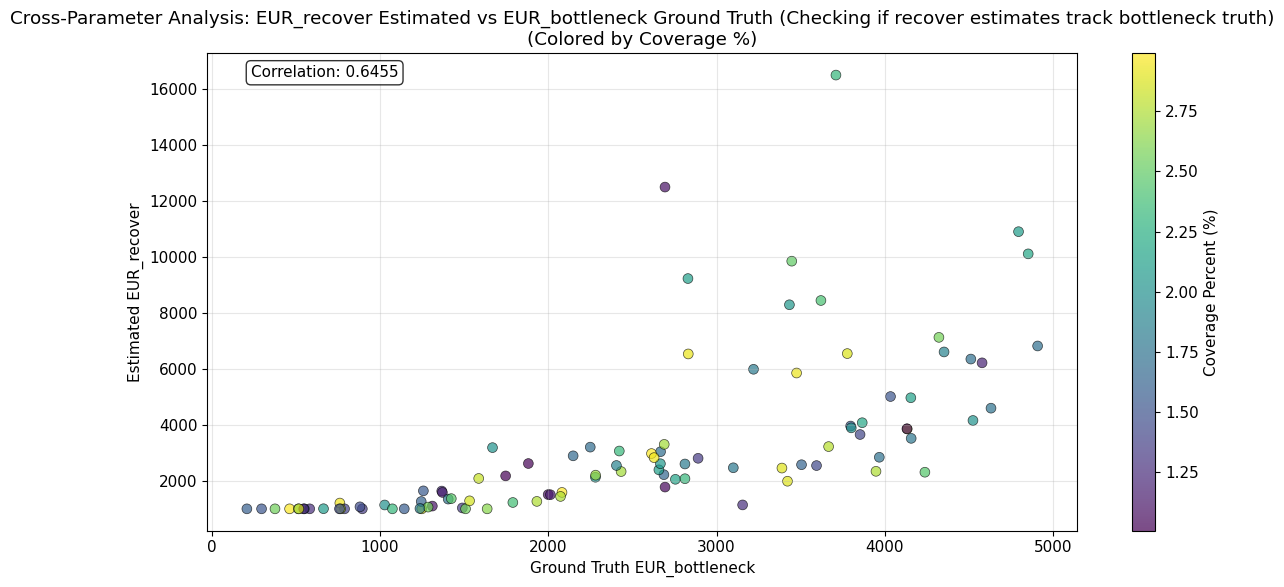

Cross-parameter correlation (EUR_recover est vs EUR_bottleneck gt): 0.6455
Data points: 100

Cross-Parameter Correlation Summary:
EUR_bottleneck est vs EUR_recover truth: 0.3307
EUR_recover est vs EUR_bottleneck truth: 0.6455

⚠️  HIGH CORRELATION DETECTED!
   This suggests potential parameter confusion between EUR_bottleneck and EUR_recover.
   The model may be having difficulty distinguishing these parameters.


In [50]:
# EUR_bottleneck vs EUR_recover cross-parameter analysis
print("EUR_bottleneck vs EUR_recover Cross-Parameter Analysis")
print("="*60)

# Check if both parameters exist in the data
available_params = df['parameter'].unique()
has_bottleneck = 'EUR_bottleneck' in available_params
has_recover = 'EUR_recover' in available_params

print(f"Available parameters: {list(available_params)}")
print(f"Has EUR_bottleneck: {has_bottleneck}")
print(f"Has EUR_recover: {has_recover}")

if has_bottleneck and has_recover:
    # Plot 1: EUR_bottleneck estimated vs EUR_recover ground truth
    print("\n1. EUR_bottleneck estimated vs EUR_recover ground truth")
    corr1 = plot_cross_parameter(df, 'EUR_bottleneck', 'EUR_recover', 
                                " (Checking if bottleneck estimates track recover truth)")
    
    # Plot 2: EUR_recover estimated vs EUR_bottleneck ground truth  
    print("\n2. EUR_recover estimated vs EUR_bottleneck ground truth")
    corr2 = plot_cross_parameter(df, 'EUR_recover', 'EUR_bottleneck',
                                " (Checking if recover estimates track bottleneck truth)")
    
    # Summary
    print(f"\nCross-Parameter Correlation Summary:")
    print(f"EUR_bottleneck est vs EUR_recover truth: {corr1:.4f}")
    print(f"EUR_recover est vs EUR_bottleneck truth: {corr2:.4f}")
    
    # Interpretation
    if abs(corr1) > 0.5 or abs(corr2) > 0.5:
        print(f"\n⚠️  HIGH CORRELATION DETECTED!")
        print(f"   This suggests potential parameter confusion between EUR_bottleneck and EUR_recover.")
        print(f"   The model may be having difficulty distinguishing these parameters.")
    else:
        print(f"\n✅ Low cross-parameter correlation - parameters appear distinguishable.")
        
elif not has_bottleneck:
    print("\n❌ EUR_bottleneck parameter not found in data")
elif not has_recover:
    print("\n❌ EUR_recover parameter not found in data")
else:
    print("\n❌ Neither EUR_bottleneck nor EUR_recover found in data")